<a href="https://colab.research.google.com/github/Nagu34/Thesis/blob/main/ESC_10_Dataset_Augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#package imports
import os
import random
import sys
import glob 
import keras

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

## extra added 
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from scipy import stats
import warnings
import seaborn as sns
import multiprocessing as mp
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from scipy import stats
import warnings
import seaborn as sns
import multiprocessing as mp
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/My Drive/ESC-50-master/meta/esc50.csv')

In [ ]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
df_10 = df[df['esc10'] == True]

In [ ]:
df_10.count

<bound method DataFrame.count of                filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
14     1-110389-A-0.wav     1       0             dog   True    110389    A
24    1-116765-A-41.wav     1      41        chainsaw   True    116765    A
54     1-17150-A-12.wav     1      12  crackling_fire   True     17150    A
55    1-172649-A-40.wav     1      40      helicopter   True    172649    A
...                 ...   ...     ...             ...    ...       ...  ...
1876   5-233160-A-1.wav     5       1         rooster   True    233160    A
1888   5-234879-A-1.wav     5       1         rooster   True    234879    A
1889   5-234879-B-1.wav     5       1         rooster   True    234879    B
1894  5-235671-A-38.wav     5      38      clock_tick   True    235671    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[400 rows x 7 columns]>

In [ ]:
src_path="/content/drive/MyDrive/ESC-50-master/audio_o"

In [ ]:
data_df = pd.DataFrame(columns=['path','sound'])
count=0
#dir_list=os.listdir(src_path)
#dir_list.sort()
for sound_files in tqdm(df_10.filename.values):
    #print(sound_files)
     sound_file= sound_files.split('.')[0].split('-')
    #print(emotion_file)
     path= src_path + '/' + sound_files
     des_path = "/content/drive/MyDrive/ESC-10-master/audio" 
     des_path1 = des_path + '/' + sound_files
     os.rename(path, des_path1)
    #print(path)
     sound=int(sound_file[3])
    #print(emotion)
     data_df.loc[count] = [path,sound]
     count += 1

100%|██████████| 400/400 [00:01<00:00, 200.70it/s]


In [ ]:
data_df

,path,sound
0,/content/drive/MyDrive/ESC-50-master/audio_o/1...,0
1,/content/drive/MyDrive/ESC-50-master/audio_o/1...,0
2,/content/drive/MyDrive/ESC-50-master/audio_o/1...,41
3,/content/drive/MyDrive/ESC-50-master/audio_o/1...,12
4,/content/drive/MyDrive/ESC-50-master/audio_o/1...,40
...,...,...
395,/content/drive/MyDrive/ESC-50-master/audio_o/5...,1
396,/content/drive/MyDrive/ESC-50-master/audio_o/5...,1
397,/content/drive/MyDrive/ESC-50-master/audio_o/5...,1
398,/content/drive/MyDrive/ESC-50-master/audio_o/5...,38


In [ ]:
data_df.sound.unique()

array([0, 41, 12, 40, 10, 20, 38, 21, 1, 11], dtype=object)

In [ ]:
import numpy as np
max_pad_len = 228
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [ ]:
src_path="/content/drive/MyDrive/emotion/audio_augmentations"

In [ ]:
data_df = pd.DataFrame(columns=['path','sound'])
count=0
features=[]
dir_list=os.listdir(src_path)
dir_list.sort()
for sound_files in tqdm(dir_list):
    #print(sound_files)
     sound_file= sound_files.split('.')[0].split('-')
    #print(emotion_file)
     path= src_path + '/' + sound_files
    #print(path)
     file_name=os.path.abspath(path)
     data = extract_features(file_name)
     sound=int(sound_file[2])
     features.append([data, sound])
    #print(emotion)
     data_df.loc[count] = [path,sound]
     count += 1
    #print("------------------------------")
    #print("++++++++++++++++++++++++++++++++++++++++++++++")
featuresdf = pd.DataFrame(features, columns=['feature','sound'])
featuresdf.to_pickle('/content/drive/MyDrive/emotion/emotion_mfcc_aug.pkl')

100%|██████████| 5760/5760 [40:04<00:00,  2.40it/s]


feature    [[-901.8272547194704, -901.8272547194704, -901...
sound                                                      2
Name: 867, dtype: object

In [ ]:
src_path="/content/drive/MyDrive/ESC-10-master/audio"
target_dir="/content/drive/MyDrive/ESC-10-master/audio_augmentations"
dir_list=os.listdir(src_path)
dir_list.sort()
for sound_files in tqdm(dir_list):
    #print(sound_files)
     sound_file= sound_files.split('.')[0].split('-')
    #print(emotion_file)
     path= src_path + '/' + sound_files
     #data, sample_rate = read_audio_file(path)
     data,sample_rate = librosa.core.load(path)
     data_noise = add_noise(data)
     outfile = sound_files.split('.')[0] + "-" + "aug" + ".wav"
     outfile = target_dir + '/' + outfile
     write_audio_file(outfile, data_noise,sample_rate)
     data_roll = shift(data,sample_rate)
     outfile = sound_files.split('.')[0] + "-" + "aug1" + ".wav"
     outfile = target_dir + '/' + outfile
     write_audio_file(outfile, data_roll,sample_rate)
     # change of pitch the sound
     data_pitch = pitch(data)
     outfile = sound_files.split('.')[0] + "-" + "aug2" + ".wav"
     outfile = target_dir + '/' + outfile
     write_audio_file(outfile, data_pitch,sample_rate)
     #change of dynamic range
     data_range = range(data_pitch)
     outfile = sound_files.split('.')[0] + "-" + "aug3" + ".wav"
     outfile = target_dir + '/' + outfile
     write_audio_file(outfile, data_range,sample_rate)

100%|██████████| 400/400 [03:46<00:00,  1.77it/s]


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt


def add_noise(data):
        data_noise = data + 0.009*np.random.normal(0,1,len(data))
        return data_noise
def shift(data,sample_rate):
        return np.roll(data,int(sample_rate/10))
def pitch(y):
    y_mod=y
    length_change = np.random.uniform(low=0.9,high=1.1)
    speed_fac = 1.0  / length_change
    #print(tab+"    resample length_change = ",length_change)
    tmp = np.interp(np.arange(0,len(y),speed_fac),np.arange(0,len(y)),y)
    #tmp = resample(y,int(length*lengt_fac))    # signal.resample is too slow
    minlen = min( y.shape[0], tmp.shape[0])     # keep same length as original; 
    y_mod *= 0                                    # pad with zeros 
    y_mod[0:minlen] = tmp[0:minlen]
    return y_mod
def range(y_mod):
    dyn_change = np.random.uniform(low=0.5,high=1.1)  # change amplitude
    #print(tab+"    dyn_change = ",dyn_change)
    y_mod = y_mod * dyn_change
    return y_mod
def write_audio_file(file, data, sample_rate):
        librosa.output.write_wav(file, data, sample_rate)

In [ ]:
def log_specgram(audio, sample_rate, window_size=5,
                 step_size=2, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False,
                            )
    return freqs, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
def wav2img(wav_path, targetdir='', figsize=(1.28,1.28)):
    """
    takes in wave file path
    and the fig size. Default 4,4 will make images 224 x 224
    """
    import pylab
    from matplotlib import cm
    pylab.figure(figsize=figsize) 
    pylab.axis('off')
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])   
    # use soundfile library to read in the wave files
    test_sound,samplerate  = librosa.load(wav_path)
    test_sound, index1= librosa.effects.trim(test_sound)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    ## create output path
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    #plt.figure(figsize=(2.24, 2.24), dpi=100)
    #plt.axis('off')
    #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    #pylab.figure(1, figsize=(2.24,2.24))
    librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time',cmap=cm.jet)
    #plt.show()
    #pylab.plot(spectrogram)
    pylab.savefig('%s.png' % output_file,bbox_inches=None, pad_inches=0,dpi=100)

    #plt.savefig('%s.png' % output_file,transparent=False,dpi=100)
    
    #plt.imsave('%s.png' % output_file, spectrogram.T)
    pylab.close()
    #plt.close()

In [ ]:
def wav2img(wav_path, targetdir='', figsize=(1.28,1.28)):
    """
    takes in wave file path
    and the fig size. Default 4,4 will make images 224 x 224
    """
    import pylab
    from matplotlib import cm
    pylab.figure(figsize=figsize) 
    pylab.axis('off')
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])   
    # use soundfile library to read in the wave files
    test_sound,samplerate  = librosa.load(wav_path)
    test_sound, index1= librosa.effects.trim(test_sound)
    #_, spectrogram = log_specgram(test_sound, samplerate)
    #hop_length = 512
    #chromagram = librosa.feature.chroma_stft(test_sound, sr=samplerate, hop_length=hop_length)
    N = 4096
    H = 512 
    eps = np.finfo(float).eps
    C = librosa.feature.chroma_stft(y=test_sound, sr=samplerate, tuning=0, norm=None, hop_length=H, n_fft=N)
    ## create output path
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    #plt.figure(figsize=(2.24, 2.24), dpi=100)
    #plt.axis('off')
    #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    #pylab.figure(1, figsize=(2.24,2.24))
    #librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time',cmap=cm.jet)
    #librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    librosa.display.specshow(10 * np.log10(eps + C), x_axis='time', y_axis='chroma', sr=samplerate, hop_length=H)
    #plt.show()
    #pylab.plot(spectrogram)
    pylab.savefig('%s.png' % output_file,bbox_inches=None, pad_inches=0,dpi=100)

    #plt.savefig('%s.png' % output_file,transparent=False,dpi=100)
    
    #plt.imsave('%s.png' % output_file, spectrogram.T)
    pylab.close()
    #plt.close()

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#splitfolders.ratio("/content/drive/MyDrive/ESC-50-master/audio_augmentations/", output="/content/drive/MyDrive/ESC-50-master/audio_augmentations1", seed=1337, ratio=(.4, .3, .3), group_prefix=None) # default values

# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
splitfolders.fixed("/content/drive/MyDrive/ESC-50-master/audio_augmentations", output="/content/drive/MyDrive/ESC-50-master/audio_augmentations1", seed=1337, fixed=(3000, 3000), oversample=False, group_prefix=None) # default values

In [ ]:
src_path="/content/drive/MyDrive/ESC-50-master/audio_augmentations1/test/audio_augmentations"

In [ ]:
target_dir="/content/drive/My Drive/ESC-50-master/ESC_RGBA_128_SPE"

In [ ]:
for file_list in tqdm(os.listdir(src_path)):
     wav2img(src_path + '/' + file_list, target_dir)
     #convert(src_path  + '/' + file_list, target_dir)


100%|██████████| 3000/3000 [1:48:35<00:00,  2.17s/it]


In [ ]:
src_path="/content/drive/MyDrive/ESC-10-master/audio_augmentations"
target_dir="/content/drive/MyDrive/ESC-10-master/ESC_RGBA_128_CHR_aug"

In [ ]:
for file_list in tqdm(os.listdir(src_path)):
     wav2img(src_path + '/' + file_list, target_dir)
     #convert(src_path  + '/' + file_list, target_dir)

100%|██████████| 1600/1600 [38:39<00:00,  1.45s/it]


In [ ]:
src_path="/content/drive/MyDrive/ESC-10-master/ESC_RGBA_128_SPE_aug"
target_dir="/content/drive/MyDrive/ESC-10-master/ESC_RGB_128_SPE_aug"

In [ ]:
from PIL import Image
from numpy import asarray

In [ ]:
def convert(png_path, targetdir=''):
    im=Image.open(png_path)
    output_file = png_path.split('/')[-1].split('.png')[0]
    output_file = targetdir +'/'+ output_file
    im.convert('RGB').save("%s.jpg" %output_file)



In [ ]:
for file_list in tqdm(os.listdir(src_path)):
     #wav2img(src_path + '/' + file_list, target_dir)
     convert(src_path  + '/' + file_list, target_dir)

100%|██████████| 1600/1600 [20:44<00:00,  1.29it/s]


In [ ]:
src_path="/content/drive/MyDrive/ESC-10-master/ESC_RGB_128_SPE_aug"

In [ ]:
data_df = pd.DataFrame(columns=['path','sound'])
count=0
dir_list=os.listdir(src_path)
dir_list.sort()
for sound_files in tqdm(dir_list):
    #print(sound_files)
     sound_file= sound_files.split('.')[0].split('-')
    #print(emotion_file)
     path= src_path + '/' + sound_files
    #print(path)
     sound=int(sound_file[3])
    #print(emotion)
     data_df.loc[count] = [path,sound]
     count += 1
    #print("------------------------------")
    #print("++++++++++++++++++++++++++++++++++++++++++++++")

100%|██████████| 1600/1600 [00:04<00:00, 397.81it/s]


In [ ]:
data_df

,path,sound
0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
2,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
3,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
4,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
...,...,...
1595,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,38
1596,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1597,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1598,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0


In [ ]:
src_path="/content/drive/MyDrive/ESC-10-master/ESC_RGB_128_CHR_aug"

In [ ]:
data_df1 = pd.DataFrame(columns=['path1','sound1'])
count=0
dir_list=os.listdir(src_path)
dir_list.sort()
for sound_files in tqdm(dir_list):
    #print(sound_files)
     sound_file= sound_files.split('.')[0].split('-')
    #print(emotion_file)
     path= src_path + '/' + sound_files
    #print(path)
     sound=int(sound_file[3])
    #print(emotion)
     data_df1.loc[count] = [path,sound]
     count += 1
    #print("------------------------------")
    #print("++++++++++++++++++++++++++++++++++++++++++++++")

100%|██████████| 1600/1600 [00:03<00:00, 400.88it/s]


In [ ]:
data_df1

,path1,sound1
0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
2,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
3,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
4,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
...,...,...
1595,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,38
1596,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1597,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1598,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0


In [ ]:
data_merged = pd.concat([data_df, data_df1], axis=1)

In [ ]:
del data_merged['sound1']

In [ ]:
data_merged


,path,sound,path1
0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
1,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
2,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
3,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
4,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
...,...,...,...
1595,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,38,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
1596,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
1597,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...
1598,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...


In [ ]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from PIL import Image
from numpy import asarray
# load the image
image = Image.open('/content/drive/My Drive/ESC-50-master/ESC_RGBA_224/2-118964-A-0.png')
# convert image to numpy array
data = asarray(image)
print(type(data))
# summarize shape
print(data.shape)

# create Pillow image
image2 = Image.fromarray(data)
print(type(image2))

# summarize image details
print(image2.mode)
print(image2.size)

<class 'numpy.ndarray'>
(224, 224, 4)
<class 'PIL.Image.Image'>
RGBA
(224, 224)


In [ ]:
def read_spectograms(file_paths, img_rows, img_cols, as_gray, channels):
  """
  Reads the spectogram files from disk and normalizes the pixel values
    @params:
      file_paths - Array of file paths to read from
      img_rows - The image height.
      img_cols - The image width.
      as_grey - Read the image as Greyscale or RGB.
      channels - Number of channels.
    @returns:
      The created and compiled model (Model)        
  """
  images = []
  
  for file_path in tqdm(file_paths):
    images.append(imread(file_path, as_gray = as_gray))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [ ]:
as_gray = False
in_channel = 3

if as_gray:
  in_channel = 1

img_rows, img_cols = 128, 128
num_classes = 10 # number of appliances

batch_size = 32
epochs = 100
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

In [ ]:
x_train_spectrogram = read_spectograms(data_merged.path.values, img_rows, img_cols, as_gray, in_channel)
np.save('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_esc_spectrogram_aug.npy', x_train_spectrogram)

100%|██████████| 1600/1600 [00:02<00:00, 663.30it/s]


In [ ]:
x_train_chroma = read_spectograms(data_merged.path1.values, img_rows, img_cols, as_gray, in_channel)
np.save('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_esc_chroma_aug.npy', x_train_chroma)

100%|██████████| 1600/1600 [16:36<00:00,  1.61it/s]


In [ ]:
data_df.replace(41,9,inplace=True)

In [ ]:
[0,1,2,3,4,5,6,7,8,9]

In [ ]:
data_df.sound.unique()

array([0, 9, 4, 8, 2, 5, 7, 6, 1, 3])

In [ ]:
data_df

,path,sound
0,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
2,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
3,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
4,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
...,...,...
1595,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,7
1596,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1597,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0
1598,/content/drive/MyDrive/ESC-10-master/ESC_RGB_1...,0


In [ ]:
labels = data_df.sound.values

# convert class vectors to binary class matrices One Hot Encoding
labels = keras.utils.to_categorical(labels, 10)

In [ ]:
labels.shape

(1600, 10)

In [ ]:
np.save('/content/drive/MyDrive/ESC-10-master/labels_128_aug.npy', labels)

In [ ]:
x_train_spectrogram, x_test_spectrogram, y_train, y_test = train_test_split(x_train_spectrogram, labels, test_size = 0.2, random_state=666)
print(y_train[10])
x_train_chroma, x_test_chroma, y_train, y_test = train_test_split(x_train_chroma, labels, test_size = 0.2, random_state=666)
print(y_train[10])

ValueError: ignored

In [ ]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
labels = data_df.sound.values

# convert class vectors to binary class matrices One Hot Encoding
labels = keras.utils.to_categorical(labels, num_classes)

In [ ]:
x_train_spectrogram = np.load('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_spectrogram_augmentedfull.npy',allow_pickle=True) 
x_train_chroma = np.load('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_chroma_augmentedfull.npy',allow_pickle=True) 
labels= np.load('/content/drive/MyDrive/ESC-10-master/labels_augmentedfull.npy',allow_pickle=True) 

In [ ]:
x_train_spectrogram.shape

(2000, 128, 128, 3)

In [ ]:
labels.shape

(2000, 10)

In [ ]:
labels_old= np.load('/content/drive/MyDrive/ESC-10-master/labels_128.npy',allow_pickle=True) 

In [ ]:
labels_old.shape

(400, 10)

In [ ]:
labels_new=np.append(labels_old,labels,axis=0)

In [ ]:
labels_new.shape

(2000, 10)

In [ ]:
np.save('/content/drive/MyDrive/ESC-10-master/labels_augmentedfull.npy', labels_new)

In [ ]:
x_train_spectrogram = np.load('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_esc_spectrogram.npy')
x_train_spectrogram_aug = np.load('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_esc_spectrogram_aug.npy')
x_train_chroma = np.load('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_esc_chroma.npy')
x_train_chroma_aug = np.load('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_esc_chroma_aug.npy')

In [ ]:
x_train_chroma_new=np.append(x_train_chroma,x_train_chroma_aug,axis=0)
np.save('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_chroma_augmentedfull.npy', x_train_chroma_new)

In [ ]:
x_train_spectrogram_new=np.append(x_train_spectrogram,x_train_spectrogram_aug,axis=0)
np.save('/content/drive/MyDrive/ESC-10-master/x_train_rgb_128_spectrogram_augmentedfull.npy', x_train_spectrogram_new)

In [ ]:
featuresdf=pd.read_pickle('/content/drive/MyDrive/ESC-10-master/esc_mfcc_aug.pkl')
featuresdf_old=pd.read_pickle('/content/drive/MyDrive/ESC-10-master/esc_mfcc.pkl')

In [ ]:
x_train_spectrogram_new.shape

(2000, 128, 128, 3)

In [ ]:
features_df=featuresdf_old.append(featuresdf)

In [ ]:
x_train_spectrogram, x_test_spectrogram, y_train, y_test = train_test_split(x_train_spectrogram, labels, test_size = 0.2, random_state=666)
x_train_chroma, x_test_chroma, y_train, y_test = train_test_split(x_train_chroma, labels, test_size = 0.2, random_state=666)

In [ ]:
features_df.to_pickle('/content/drive/MyDrive/ESC-10-master/mfcc_augemtedfull_128.pkl')

In [ ]:
#x_train_spectrogram = np.load('/content/drive/My Drive/UrbanSound8K/x_train_rgb_224_spectrogram.npy') 
x_train_spectrogram, x_test_spectrogram, y_spec_train, y_spec_test = train_test_split(x_train_spectrogram, labels, test_size = 0.2, random_state=666)
x_train_chroma, x_test_chroma, y_chr_train, y_chr_test = train_test_split(x_train_chroma, labels, test_size = 0.2, random_state=666)

In [ ]:
#x_train_spectrogram = np.load('/content/drive/My Drive/UrbanSound8K/x_train_rgb_224_spectrogram.npy') 
x_val_spectrogram, x_test_spectrogram, y_val, y_test = train_test_split(x_test_spectrogram, y_spec_test, test_size = 0.5, random_state=666)
x_val_chroma, x_test_chroma, y_val, y_test = train_test_split(x_test_chroma, y_chr_test, test_size = 0.5, random_state=666)

In [ ]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)

  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)

  
  model = GlobalAveragePooling2D()(model)

  #model = Flatten()(model)
    
  return model

In [ ]:
def create_convolution_layers1(input_img):
    base_model2 = keras.applications.InceptionV3(weights='imagenet',include_top=False)
    x = base_model2(input_img, training=True)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    return x


In [ ]:
def create_convolution_layers2(input_img):
    base_model2 = keras.applications.VGG19(weights='imagenet',include_top=False)
    x = base_model2(input_img, training=True)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    return x

In [ ]:
def create_convolution_layers3(input_img):
    base_model2 = keras.applications.Xception(weights='imagenet',include_top=False)
    x = Conv2D(3,(3,3),padding='same')(input_img)
    x = base_model2(x, training=True)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    return x

In [ ]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same',activation='relu' ,input_shape=input_shape)(input_img)
  model = BatchNormalization()(model) 
  model = Conv2D(32,(3,3),activation='relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same',activation='relu')(model)
  model = BatchNormalization()(model) 
  model = Conv2D(64, (3, 3),activation='relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(64, (3, 3), padding='same',activation='relu')(model)
  model = BatchNormalization()(model) 
  model = Conv2D(64, (3, 3), activation='relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)

  model = Conv2D(128, (3, 3), padding='same',activation='relu')(model)
  model = BatchNormalization()(model) 
  model = Conv2D(128, (3, 3), activation='relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)

  model = GlobalAveragePooling2D()(model)

  #model = Flatten()(model)
    
  return model

In [ ]:
def create_convolution_layer(input_img):
  model = Conv2D(32, (3, 3), padding='same',kernel_regularizer=regularizers.l2(1e-4) ,input_shape=input_shape)(input_img)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  model = Conv2D(32,(3,3),kernel_regularizer=regularizers.l2(1e-4))(model)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2))(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(1e-4))(model)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  model = Conv2D(64,(3,3),kernel_regularizer=regularizers.l2(1e-4))(model)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2))(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(1e-4))(model)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  model = Conv2D(64,(3,3),kernel_regularizer=regularizers.l2(1e-4))(model)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2))(model)
  model = Dropout(0.25)(model)

  model = Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(1e-4))(model)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  model = Conv2D(128,(3,3),kernel_regularizer=regularizers.l2(1e-4))(model)
  model = Activation('relu')(model)
  model = BatchNormalization()(model) 
  #model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2))(model)
  model = Dropout(0.4)(model)

  model = GlobalAveragePooling2D()(model)

  #model = Flatten()(model)
    
  return model

In [ ]:
def create_convolution_layers3(input_img):
    base_model2 = keras.applications.Xception(weights='imagenet',include_top=False)
    x = Conv2D(3,(3,3),padding='same')(input_img)
    x = base_model2(x, training=True)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    return x

In [ ]:
def create_convolution_layers1(input_img):
    x = Conv2D(3,(3,3),padding='same')(input_img)
    conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
    conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
    pool1  = MaxPooling2D((2, 2))(conv2)
    conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
    conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
    pool2  = MaxPooling2D((2, 2))(conv4)
    conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
    conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
    conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
    pool3  = MaxPooling2D((2, 2))(conv7)
    conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
    conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
    conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
    pool4  = MaxPooling2D((2, 2))(conv10)
    conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
    conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
    conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
    pool5  = MaxPooling2D((2, 2))(conv13)

    model = GlobalAveragePooling2D()(pool5)
    return model

In [ ]:
as_gray = False
in_channel = 3

if as_gray:
  in_channel = 1

img_rows, img_cols = 128,128
num_classes = 10 # number of appliances

batch_size = 32
epochs = 100
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

In [ ]:
spectrogram_input = Input(shape=input_shape)
spectrogram_model = create_convolution_layers(spectrogram_input)

chroma_input = Input(shape=input_shape)
chroma_model = create_convolution_layers(chroma_input)

In [ ]:
featuresdf=pd.read_pickle('/content/drive/MyDrive/ESC-10-master/mfcc_augemtedfull_128.pkl')

In [ ]:
X = np.array(featuresdf.feature.tolist())

In [ ]:
X.shape

(2000, 40, 217)

In [ ]:
x_train_mfcc, x_test_mfcc, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state = 666)

num_rows = 40
num_columns = 217
num_channels = 1

x_train_mfcc = x_train_mfcc.reshape(x_train_mfcc.shape[0], num_rows, num_columns, num_channels)
x_test_mfcc = x_test_mfcc.reshape(x_test_mfcc.shape[0], num_rows, num_columns, num_channels)

In [ ]:
x_train_mfcc, x_test_mfcc, y_mfcc_train, y_mfcc_test = train_test_split(X, labels, test_size=0.2, random_state = 666)
x_val_mfcc, x_test_mfcc, y_val, y_test = train_test_split(x_test_mfcc, y_mfcc_test, test_size = 0.5, random_state=666)

num_rows = 40
num_columns = 217
num_channels = 1

x_train_mfcc = x_train_mfcc.reshape(x_train_mfcc.shape[0], num_rows, num_columns, num_channels)
x_test_mfcc = x_test_mfcc.reshape(x_test_mfcc.shape[0], num_rows, num_columns, num_channels)
x_val_mfcc = x_val_mfcc.reshape(x_val_mfcc.shape[0], num_rows, num_columns, num_channels)

In [ ]:
num_rows = 40
num_columns = 217
num_channels = 1
input_shape=(num_rows, num_columns, num_channels)
mfcc_input = Input(shape=input_shape)
mfcc_model = create_convolution_layers(mfcc_input)

In [ ]:


#chroma_input = Input(shape=input_shape)
#chroma_model = create_convolution_layers(chroma_input)

conv = concatenate([spectrogram_model,chroma_model,mfcc_model])

#conv = Flatten()(conv)

dense = Dense(512)(conv)
model = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[spectrogram_input,chroma_input,mfcc_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 40, 217, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_3[0][0]                    
_______________________________________________________________________________________

In [ ]:
import torch

In [ ]:
labels.shape

(2000, 10)

In [ ]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 200
num_batch_size = 50


#checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/ESC-50-master/weights.best.basic_cnn.hdf5', verbose=1, save_best_only=True)
#callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
start = datetime.now()




history=model.fit([x_train_spectrogram,x_train_chroma,x_train_mfcc], y_spec_train,
          batch_size=num_batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=([x_val_spectrogram,x_val_chroma,x_val_mfcc], y_val),shuffle=True)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
32/32 [==============================] - 1s 45ms/step - loss: 2.5993 - accuracy: 0.2438 - val_loss: 1.6794 - val_accuracy: 0.4000
Epoch 2/200
32/32 [==============================] - 1s 38ms/step - loss: 1.2872 - accuracy: 0.5113 - val_loss: 1.1209 - val_accuracy: 0.6350
Epoch 3/200
32/32 [==============================] - 1s 37ms/step - loss: 0.8630 - accuracy: 0.6844 - val_loss: 0.9154 - val_accuracy: 0.6700
Epoch 4/200
32/32 [==============================] - 1s 38ms/step - loss: 0.6768 - accuracy: 0.7713 - val_loss: 0.6546 - val_accuracy: 0.7950
Epoch 5/200
32/32 [==============================] - 1s 38ms/step - loss: 0.5393 - accuracy: 0.8100 - val_loss: 0.4916 - val_accuracy: 0.8550
Epoch 6/200
32/32 [==============================] - 1s 38ms/step - loss: 0.3836 - accuracy: 0.8681 - val_loss: 0.4488 - val_accuracy: 0.8350
Epoch 7/200
32/32 [==============================] - 1s 38ms/step - loss: 0.3449 - accuracy: 0.8769 - val_loss: 0.4339 - val_accuracy: 0.8400
Epoch 

In [ ]:

final_loss, final_acc = model.evaluate([x_test_spectrogram,x_test_chroma,x_test_mfcc], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))


13/13 [==============================] - 0s 11ms/step - loss: 0.0198 - accuracy: 0.9950
Final loss: 0.019803, final accuracy: 0.995000


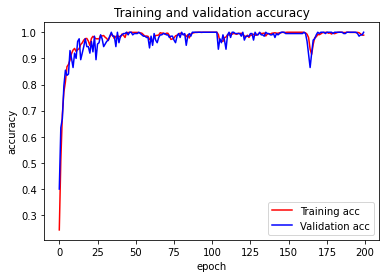

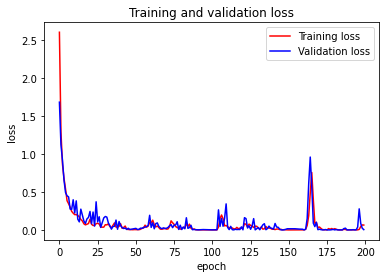

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:

final_loss, final_acc = model.evaluate([x_test_chroma,x_test_mfcc],y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

final_loss, final_acc = model.evaluate([x_val_chroma,x_val_mfcc], y_val, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))



7/7 [==============================] - 0s 9ms/step - loss: 0.0343 - accuracy: 0.9950
Final loss: 0.034285, final accuracy: 0.995000
7/7 [==============================] - 0s 10ms/step - loss: 0.0556 - accuracy: 0.9900
Final loss: 0.055641, final accuracy: 0.990000


In [ ]:
score = model.evaluate([x_train_chroma,x_train_mfcc], y_spec_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate([x_test_chroma,x_test_mfcc], y_test, verbose=0)
print("Test Accuracy: ", score[1])

score = model.evaluate([x_val_chroma,x_val_mfcc], y_val, verbose=0)
print("val Accuracy: ", score[1])

Training Accuracy:  0.9993749856948853
Test Accuracy:  0.9950000047683716
val Accuracy:  0.9900000095367432


In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate([x_train_spectrogram,x_train_chroma,x_train_mfcc], y_spec_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate([x_val_spectrogram,x_val_chroma,x_val_mfcc], y_val, verbose=0)
print("Val Accuracy: ", score[1])

score = model.evaluate([x_test_spectrogram,x_test_chroma,x_test_mfcc], y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Val Accuracy:  1.0
Testing Accuracy:  0.9800000190734863


In [ ]:
score = model.evaluate([x_test_spectrogram[1],x_test_chroma[1],x_test_mfcc[1]], y_test[1], verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

ValueError: ignored

In [ ]:

final_loss, final_acc = model.evaluate([x_test_spectrogram,x_test_chroma,x_test_mfcc], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

final_loss, final_acc = model.evaluate([x_val_spectrogram,x_val_chroma,x_val_mfcc], y_val, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))



7/7 [==============================] - 0s 11ms/step - loss: 0.0411 - accuracy: 0.9800
Final loss: 0.041077, final accuracy: 0.980000
7/7 [==============================] - 0s 10ms/step - loss: 0.0038 - accuracy: 1.0000
Final loss: 0.003788, final accuracy: 1.000000


In [ ]:
model.load_weights("/content/drive/My Drive/UrbanSound8K/weights.best.basic_cnn.hdf5")

In [ ]:

# Evaluating the model on the training and testing set
score = model.evaluate([x_train_spectrogram,x_train_chroma,x_train_mfcc], y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate([x_test_spectrogram,x_test_chroma,x_test_mfcc], y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Testing Accuracy:  0.9950000047683716


In [ ]:
#print('test data', test_data)
preds = np.round(model.predict([x_test_spectrogram,x_test_chroma,x_test_mfcc]),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
#print('rounded test_labels', preds)

In [ ]:
Classes_List=['dog','rooster', 'rain','sea_waves' ,'crackling_fire', 'crying_baby','sneezing' ,'clock_tick','helicopter','chainsaw']

In [ ]:
import sklearn.metrics as metrics
classification_metrics = metrics.classification_report(y_test, preds, target_names=Classes_List )
print(classification_metrics)

                precision    recall  f1-score   support

           dog       1.00      1.00      1.00        18
       rooster       1.00      1.00      1.00        16
          rain       1.00      1.00      1.00        20
     sea_waves       1.00      0.95      0.98        21
crackling_fire       0.91      1.00      0.95        30
   crying_baby       1.00      1.00      1.00        17
      sneezing       0.95      1.00      0.97        18
    clock_tick       1.00      0.88      0.93        24
    helicopter       1.00      1.00      1.00        18
      chainsaw       1.00      1.00      1.00        18

     micro avg       0.98      0.98      0.98       200
     macro avg       0.99      0.98      0.98       200
  weighted avg       0.98      0.98      0.98       200
   samples avg       0.98      0.98      0.98       200



In [ ]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [ ]:
#To get better visual of the confusion matrix:
from itertools import product
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


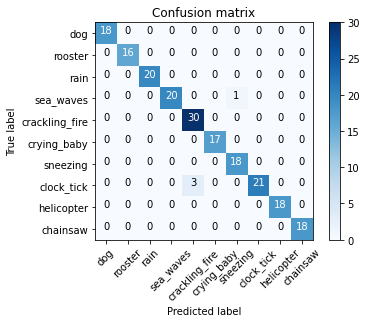

In [ ]:
plot_confusion_matrix(confusion_matrix, Classes_List)

Normalized confusion matrix


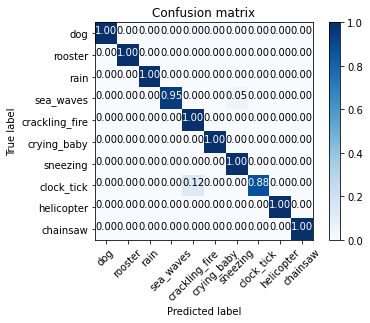

In [ ]:
plot_confusion_matrix(confusion_matrix, Classes_List,normalize=True)